The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Queries, Keys, and Values
:label:`sec_queries-keys-values`

So far all the networks we have reviewed crucially relied on the input being of a well-defined size. For instance, the images in ImageNet are of size $224 \times 224$ pixels and CNNs are specifically tuned to this size. Even in natural language processing the input size for RNNs is well defined and fixed. Variable size is addressed by sequentially processing one token at a time, or by specially designed convolution kernels :cite:`Kalchbrenner.Grefenstette.Blunsom.2014`. This approach can lead to significant problems when the input is truly of varying size with varying information content, such as in :numref:`sec_seq2seq` in the transformation of text :cite:`Sutskever.Vinyals.Le.2014`. In particular, for long sequences it becomes quite difficult to keep track of everything that has already been generated or even viewed by the network. Even explicit tracking heuristics such as proposed by :citet:`yang2016neural` only offer limited benefit.

Compare this to databases. In their simplest form they are collections of keys ($k$) and values ($v$). For instance, our database $\mathcal{D}$ might consist of tuples \{("Zhang", "Aston"), ("Lipton", "Zachary"), ("Li", "Mu"), ("Smola", "Alex"), ("Hu", "Rachel"), ("Werness", "Brent")\} with the last name being the key and the first name being the value. We can operate on $\mathcal{D}$, for instance with the exact query ($q$) for "Li" which would return the value "Mu". If ("Li", "Mu") was not a record in $\mathcal{D}$, there would be no valid answer. If we also allowed for approximate matches, we would retrieve ("Lipton", "Zachary") instead. This quite simple and trivial example nonetheless teaches us a number of useful things:

* We can design queries $q$ that operate on ($k$,$v$) pairs in such a manner as to be valid regardless of the  database size.
* The same query can receive different answers, according to the contents of the database.
* The "code" being executed for operating on a large state space (the database) can be quite simple (e.g., exact match, approximate match, top-$k$).
* There is no need to compress or simplify the database to make the operations effective.

Clearly we would not have introduced a simple database here if it wasn't for the purpose of explaining deep learning. Indeed, this leads to one of the most exciting concepts introduced in deep learning in the past decade: the *attention mechanism* :cite:`Bahdanau.Cho.Bengio.2014`. We will cover the specifics of its application to machine translation later. For now, simply consider the following: denote by $\mathcal{D} \stackrel{\textrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$ a database of $m$ tuples of *keys* and *values*. Moreover, denote by $\mathbf{q}$ a *query*. Then we can define the *attention* over $\mathcal{D}$ as

$$\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$$
:eqlabel:`eq_attention_pooling`

where $\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}$ ($i = 1, \ldots, m$) are scalar attention weights. The operation itself is typically referred to as *attention pooling*. The name *attention* derives from the fact that the operation pays particular attention to the terms for which the weight $\alpha$ is significant (i.e., large). As such, the attention over $\mathcal{D}$ generates a linear combination of values contained in the database. In fact, this contains the above example as a special case where all but one weight is zero. We have a number of special cases:

* The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ are nonnegative. In this case the output of the attention mechanism is contained in the convex cone spanned by the values $\mathbf{v}_i$.
* The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ form a convex combination, i.e., $\sum_i \alpha(\mathbf{q}, \mathbf{k}_i) = 1$ and $\alpha(\mathbf{q}, \mathbf{k}_i) \geq 0$ for all $i$. This is the most common setting in deep learning.
* Exactly one of the weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ is $1$, while all others are $0$. This is akin to a traditional database query.
* All weights are equal, i.e., $\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{1}{m}$ for all $i$. This amounts to averaging across the entire database, also called average pooling in deep learning.

A common strategy for ensuring that the weights sum up to $1$ is to normalize them via

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{q}, \mathbf{k}_j)}.$$

In particular, to ensure that the weights are also nonnegative, one can resort to exponentiation. This means that we can now pick *any* function  $a(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it via

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}. $$
:eqlabel:`eq_softmax_attention`

This operation is readily available in all deep learning frameworks. It is differentiable and its gradient never vanishes, all of which are desirable properties in a model. Note though, the attention mechanism introduced above is not the only option. For instance, we can design a non-differentiable attention model that can be trained using reinforcement learning methods :cite:`Mnih.Heess.Graves.ea.2014`. As one would expect, training such a model is quite complex. Consequently the bulk of modern attention research
follows the framework outlined in :numref:`fig_qkv`. We thus focus our exposition on this family of differentiable mechanisms.

![The attention mechanism computes a linear combination over values $\mathbf{v}_\mathit{i}$ via attention pooling,
where weights are derived according to the compatibility between a query $\mathbf{q}$ and keys $\mathbf{k}_\mathit{i}$.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/qkv.svg?raw=1)
:label:`fig_qkv`

What is quite remarkable is that the actual "code" for executing on the set of keys and values, namely the query, can be quite concise, even though the space to operate on is significant. This is a desirable property for a network layer as it does not require too many parameters to learn. Just as convenient is the fact that attention can operate on arbitrarily large databases without the need to change the way the attention pooling operation is performed.


In [2]:
import torch
from d2l import torch as d2l

## Visualization

One of the benefits of the attention mechanism is that it can be quite intuitive, particularly when the weights are nonnegative and sum to $1$. In this case we might *interpret* large weights as a way for the model to select components of relevance. While this is a good intuition, it is important to remember that it is just that, an *intuition*. Regardless, we may want to visualize its effect on the given set of keys when applying a variety of different queries. This function will come in handy later.

We thus define the `show_heatmaps` function. Note that it does not take a matrix (of attention weights) as its input but rather a tensor with four axes, allowing for an array of different queries and weights. Consequently the input `matrices` has the shape (number of rows for display, number of columns for display, number of queries, number of keys). This will come in handy later on when we want to visualize the workings that are to design Transformers.


In [3]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

As a quick sanity check let's visualize the identity matrix, representing a case
where the attention weight is $1$ only when the query and the key are the same.


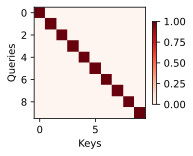

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Summary

The attention mechanism allows us to aggregate data from many (key, value) pairs. So far our discussion was
quite abstract, simply describing a way to pool data. We have not explained yet where those mysterious queries, keys, and values might arise from. Some intuition might help here: for instance, in a regression setting, the query might correspond to the location where the regression should be carried out. The keys are the locations where past data was observed and the values are the (regression) values themselves. This is the so-called Nadaraya--Watson estimator :cite:`Nadaraya.1964,Watson.1964` that we will be studying in the next section.

By design, the attention mechanism provides a *differentiable* means of control
by which a neural network can select elements from a set and to construct an associated weighted sum over representations.

## Exercises

1. Suppose that you wanted to reimplement approximate (key, query) matches as used in classical databases, which attention function would you pick?
1. Suppose that the attention function is given by $a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i$ and that $\mathbf{k}_i = \mathbf{v}_i$ for $i = 1, \ldots, m$. Denote by $p(\mathbf{k}_i; \mathbf{q})$ the probability distribution over keys when using the softmax normalization in :eqref:`eq_softmax_attention`. Prove that $\nabla_{\mathbf{q}} \mathop{\textrm{Attention}}(\mathbf{q}, \mathcal{D}) = \textrm{Cov}_{p(\mathbf{k}_i; \mathbf{q})}[\mathbf{k}_i]$.
1. Design a differentiable search engine using the attention mechanism.
1. Review the design of the Squeeze and Excitation Networks :cite:`Hu.Shen.Sun.2018` and interpret them through the lens of the attention mechanism.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DifferentiableSearchEngine(nn.Module):
    def __init__(self, d):
        super(DifferentiableSearchEngine, self).__init__()
        # Learnable linear transformations for queries, keys, and values
        self.query_transform = nn.Linear(d, d, bias=False)
        self.key_transform = nn.Linear(d, d, bias=False)
        self.value_transform = nn.Linear(d, d, bias=False)

    def forward(self, query, keys, values):
        """
        Perform the differentiable search operation.

        Parameters:
        - query (torch.Tensor): The query vector of shape (batch_size, d)
        - keys (torch.Tensor): The key vectors of shape (batch_size, n, d)
        - values (torch.Tensor): The value vectors of shape (batch_size, n, d)

        Returns:
        - torch.Tensor: The output of the search operation, weighted sum of values
        """
        # Apply learnable transformations
        transformed_query = self.query_transform(query)  # Shape: (batch_size, d)
        transformed_keys = self.key_transform(keys)  # Shape: (batch_size, n, d)
        transformed_values = self.value_transform(values)  # Shape: (batch_size, n, d)

        # Compute similarities between query and keys
        similarities = torch.bmm(transformed_keys, transformed_query.unsqueeze(-1)).squeeze(-1)  # Shape: (batch_size, n)

        # Normalize similarities using softmax
        attention_weights = F.softmax(similarities, dim=1)  # Shape: (batch_size, n)

        # Perform attention pooling over values
        output = torch.bmm(attention_weights.unsqueeze(1), transformed_values).squeeze(1)  # Shape: (batch_size, d)
        return output


In [19]:
def generate_toy_data(batch_size, n_keys, d):
    queries = torch.rand(batch_size, d)  # Query vectors
    keys = torch.rand(batch_size, n_keys, d)  # Key vectors
    values = torch.rand(batch_size, n_keys, d)  # Value vectors
    EX  = torch.mean(values, dim=1)  # For simplicity, target is the mean of values
    return queries, keys, values, targets



In [22]:
# Training Loop
def train_differentiable_search_engine():
    # Hyperparameters
    batch_size = 32
    n_keys = 5
    d = 4  # Dimension of query, key, and value vectors
    num_epochs = 50
    learning_rate = 0.01

    # Initialize model, loss function, and optimizer
    model = DifferentiableSearchEngine(d)
    criterion = nn.MSELoss()  # Mean squared error loss for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        # Generate a batch of toy data
        queries, keys, values, targets = generate_toy_data(batch_size, n_keys, d)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(queries, keys, values)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print loss for every epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

In [23]:
train_differentiable_search_engine()

Epoch [1/50], Loss: 0.3142
Epoch [2/50], Loss: 0.2962
Epoch [3/50], Loss: 0.2779
Epoch [4/50], Loss: 0.2705
Epoch [5/50], Loss: 0.2330
Epoch [6/50], Loss: 0.2460
Epoch [7/50], Loss: 0.2102
Epoch [8/50], Loss: 0.2062
Epoch [9/50], Loss: 0.1732
Epoch [10/50], Loss: 0.1721
Epoch [11/50], Loss: 0.1599
Epoch [12/50], Loss: 0.1536
Epoch [13/50], Loss: 0.1407
Epoch [14/50], Loss: 0.1374
Epoch [15/50], Loss: 0.1325
Epoch [16/50], Loss: 0.1104
Epoch [17/50], Loss: 0.1029
Epoch [18/50], Loss: 0.1026
Epoch [19/50], Loss: 0.0945
Epoch [20/50], Loss: 0.0842
Epoch [21/50], Loss: 0.0846
Epoch [22/50], Loss: 0.0728
Epoch [23/50], Loss: 0.0733
Epoch [24/50], Loss: 0.0886
Epoch [25/50], Loss: 0.0625
Epoch [26/50], Loss: 0.0815
Epoch [27/50], Loss: 0.0499
Epoch [28/50], Loss: 0.0548
Epoch [29/50], Loss: 0.0660
Epoch [30/50], Loss: 0.0557
Epoch [31/50], Loss: 0.0488
Epoch [32/50], Loss: 0.0335
Epoch [33/50], Loss: 0.0442
Epoch [34/50], Loss: 0.0516
Epoch [35/50], Loss: 0.0507
Epoch [36/50], Loss: 0.0342
E

[Discussions](https://discuss.d2l.ai/t/1592)
